In [47]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

class QKDSystem2Decoy:
    def __init__(self, e_detector=0.033, Y0=1.7e-6, eta_bob=0.045, e_0=0.5, alpha=0.21, N=2, fe=1, q = 0.5):
        self.e_detector = e_detector
        self.Y0 = Y0
        self.eta_bob = eta_bob
        self.e_0 = e_0
        self.alpha = alpha
        self.N = N
        self.fe = fe
        self.q = q

    def eta(self, L):
        return 10 ** (-self.alpha * L / 10) * self.eta_bob

    def Q(self, mu, L):
        return self.Y0 + 1 - np.exp(-self.eta(L) * mu)

    def QBER(self, mu, L):
        return self.e_0 * self.Y0 + self.e_detector * (1 - np.exp(-self.eta(L) * mu))

    def compute_Yi(self, mu, nu1, nu2, L):
        b_eq = [
            self.Q(mu, L) * np.exp(mu) - self.Y0,
            self.Q(nu1, L) * np.exp(nu1) - self.Y0,
            self.Q(nu2, L) * np.exp(nu2) - self.Y0,
        ]
        
        coefficients_mu = np.zeros(self.N)
        coefficients_nu1 = np.zeros(self.N)
        coefficients_nu2 = np.zeros(self.N)

        for i in range(1, self.N + 1):
            coefficients_mu[i - 1] = mu ** i / np.math.factorial(i)
            coefficients_nu1[i - 1] = nu1 ** i / np.math.factorial(i)
            coefficients_nu2[i - 1] = nu2 ** i / np.math.factorial(i)

        A_eq = [coefficients_mu, coefficients_nu1, coefficients_nu2]

        c = np.zeros(self.N)
        c[0] = 1

        # Solve the linear programming problem
        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        return result.x

    def compute_ei(self, mu, nu1, nu2, L):
        Yi = self.compute_Yi(mu, nu1, nu2, L)

        b_eq = [
            self.QBER(mu, L) * np.exp(mu) - self.e_0 * self.Y0,
            self.QBER(nu1, L) * np.exp(nu1) - self.e_0 * self.Y0,
            self.QBER(nu2, L) * np.exp(nu2) - self.e_0 * self.Y0,
        ]
        
        coefficients_mu = np.zeros(self.N)
        coefficients_nu1 = np.zeros(self.N)
        coefficients_nu2 = np.zeros(self.N)
        
        for i in range(1, self.N + 1):
            coefficients_mu[i - 1] = mu ** i / np.math.factorial(i) * Yi[i - 1]
            coefficients_nu1[i - 1] = nu1 ** i / np.math.factorial(i) * Yi[i - 1]
            coefficients_nu2[i - 1] = nu2 ** i / np.math.factorial(i) * Yi[i - 1]
            
        A_eq = [coefficients_mu, coefficients_nu1, coefficients_nu2]

        c = np.zeros(self.N)
        c[0] = -1

        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 0.99))
        return Yi[0], result.x[0]

    @staticmethod
    def H2(e1):
        return -e1 * np.log2(e1) - (1 - e1) * np.log2(1 - e1)

    def compute_R(self, mu, nu1, nu2, L):
        Y1, e1 = self.compute_ei(mu, nu1, nu2, L)
        Q1 = Y1 * mu * np.exp(-mu)
        Q_mu = self.Y0 + 1 - np.exp(-self.eta(L) * mu)

        E_mu = self.QBER(mu, L) / self.Q(mu, L)

        return (-Q_mu * self.fe * self.H2(E_mu) + Q1 * (1 - self.H2(e1))) * self.q

    def get_R_vs_mu(self, mu_list, nu1, nu2, L):
        R_list = [self.compute_R(mu, nu1, nu2, L) for mu in mu_list]

        return R_list

## Optimal $\mu$

$$\mu= 0.54$$
In the paper
$$\mu=0.48$$

mu_opt =  0.5353535353535354


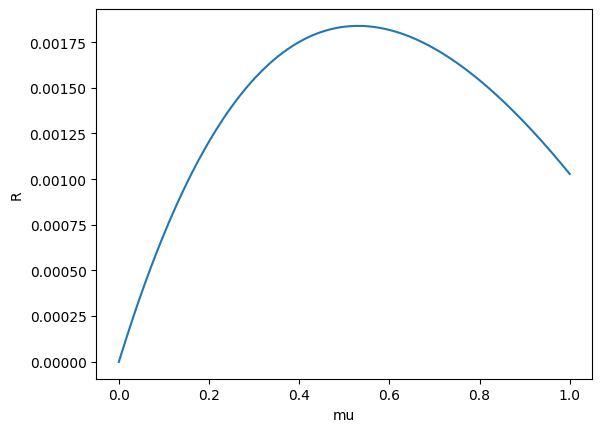

In [48]:
qkd_system_2_decoy = QKDSystem2Decoy(N=150, fe=1.2)

mu_list = np.linspace(0, 1, 100)
nu1 = 0.05
nu2 = 0
L = 10
R_list = qkd_system_2_decoy.get_R_vs_mu(mu_list, nu1, nu2, L)

plt.plot(mu_list, R_list)
plt.xlabel("mu")
plt.ylabel("R")

# Get the optimal value of mu
mu_opt = mu_list[np.argmax(R_list)]
print("mu_opt = ", mu_opt)

# Save plot in HD
plt.savefig("decoy.png", dpi=300)


## Rate vs Distance

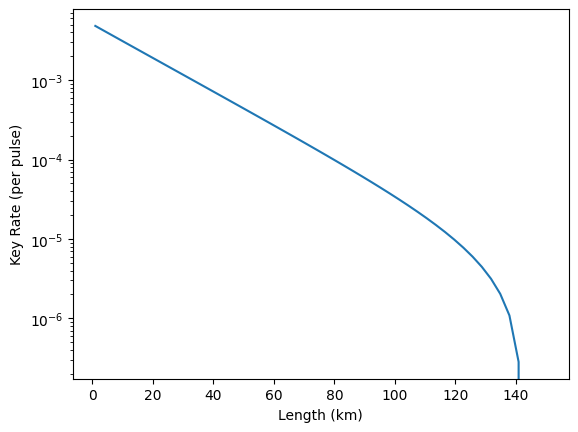

In [51]:
def get_R_2_decoy(L):
    qkd_system_2_decoy = QKDSystem2Decoy(N=10, fe=1.2, q = 1)
    nu1 = 0.05
    nu2 = 0.0
    mu = 0.48
    return qkd_system_2_decoy.compute_R(mu, nu1, nu2, L)

L = np.linspace(1, 150, 50)
R_list_2_decoy = [get_R_2_decoy(l) for l in L]

plt.plot(L, R_list_2_decoy)
plt.xlabel("Length (km)")
plt.ylabel("Key Rate (per pulse)")
plt.yscale('log')

# Save plot in HD
plt.savefig("decoy2.png", dpi=300)

In [8]:
# Get the slope of the first part of the curve (on the log scale)

slope = (np.log(R_list_2_decoy[10]) - np.log(R_list_2_decoy[0])) / ((L[10]) - (L[0]))
print("slope = ", slope)

slope =  -0.04857359918002819


In [9]:
(np.log(0.0025) - np.log(0.00002))/100

0.04828313737302301

## TODO
- check slope (done)
- curve in Fig 2 can have an analytic expression using equations / parameters from paper
- error estimate (see below)
    - plot graph for different N
- check other papers to see if there are similar results

1/10!

N = 10
N = 15
N = 20

(1) experimentally estimate error
(2) similar to the other paper, write equality constraints as inequality constraints 